In [130]:
import numpy as np
import matplotlib.pyplot as plt
import os, pickle
from agent_replay import Agent 
from utils import plot_maze, load_env

In [131]:
env            = 'tolman123'
env_file_path  = '/home/georgy/Documents/Dayan_lab/PhD/bandits/maze/code/mazes/' + env + '.txt'
env_config     = load_env(env_file_path)

# --- Specify agent parameters ---
ag_config = {
    'alpha'          : 1,         # online learning rate
    'alpha_r'        : 1,         # offline learning rate
    'online_beta'    : 15,         # online inverse temperature
    'gain_beta'      : 30,        # gain inverse temperature
    'need_beta'      : 15,         # need inverse temperature
    'policy_type'    : 'softmax', # policy type [softmax / greedy]
    'gamma'          : 0.9,       # discount factor
    'horizon'        : 10,        # planning horizon (minus 1)
    'xi'             : 0.01,      # EVB replay threshold
    'num_sims'       : 2000,      # number of MC simulations for need
    'sequences'      : True,
    'max_seq_len'    : 4,        
    'env_name'       : env        # gridworld name
}

agent = Agent(*[ag_config, env_config])

In [132]:
Q_MB  = agent._solve_mb(1e-5, barriers=[1, 0, 0])

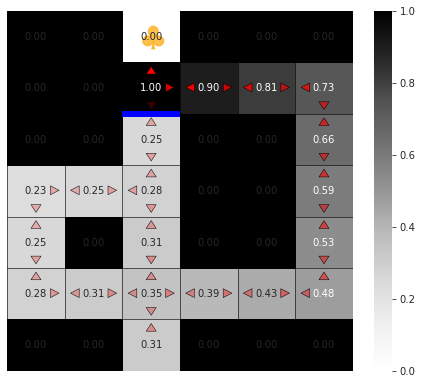

In [133]:
fig = plt.figure(figsize=(6, 5))
ax  = fig.add_axes([0, 0, 1, 1])
plot_maze(ax, Q_MB, agent)
plt.savefig('/home/georgy/Documents/Dayan_lab/PhD/bandits/maze/data/replay/examples/tolman123/q_mb.pdf', transparent=True)

### Example replays

In [134]:
agent.state = 38          # start state
agent.M     = np.array([[1, 0], [1, 0], [1, 0]])
agent.Q     = Q_MB.copy() # set MF Q values
Q_history, gain_history, need_history = agent._replay()

1 - Replay 1/4 [<14, (1.00, 1.00, 1.00)>, 0] horizon 4, q_old: 0.23, q_new: 0.90, gain: 0.44, need: 0.02, evb: 0.01
1 - Replay 2/4 [<20, (1.00, 1.00, 1.00)>, 0] horizon 3, q_old: 0.23, q_new: 0.81, gain: 0.46, need: 0.10, evb: 0.06
1 - Replay 3/4 [<26, (1.00, 1.00, 1.00)>, 0] horizon 2, q_old: 0.25, q_new: 0.73, gain: 0.36, need: 0.34, evb: 0.18
1 - Replay 4/4 [<32, (1.00, 1.00, 1.00)>, 0] horizon 1, q_old: 0.28, q_new: 0.66, gain: 0.29, need: 2.10, evb: 0.79


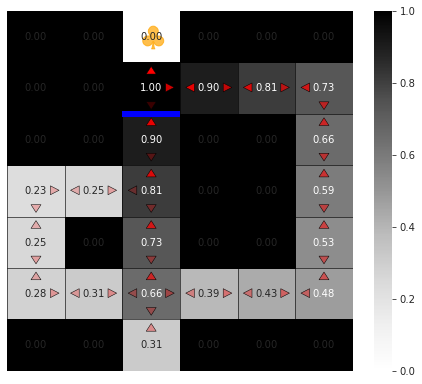

In [135]:
fig = plt.figure(figsize=(6, 5))
ax  = fig.add_axes([0, 0, 1, 1])
plot_maze(ax, agent.Q, agent)
plt.savefig('/home/georgy/Documents/Dayan_lab/PhD/bandits/maze/data/replay/examples/tolman123/replay_explore.pdf', transparent=True)

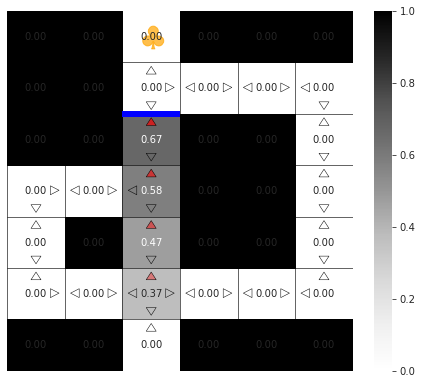

In [136]:
fig = plt.figure(figsize=(6, 5))
ax  = fig.add_axes([0, 0, 1, 1])
plot_maze(ax, agent.Q - Q_MB, agent)
plt.savefig('/home/georgy/Documents/Dayan_lab/PhD/bandits/maze/data/replay/examples/tolman123/replay_explore_diff.pdf', transparent=True)

In [137]:
Q              = agent.Q.copy()
Q_before       = Q.copy()
Q_after        = Q.copy()
Q_after[14, 0] = 0.0
agent.Q        = Q_after.copy()

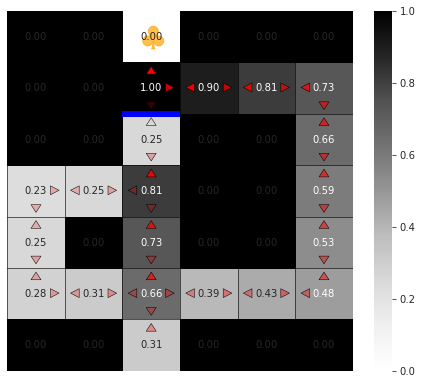

In [138]:
fig = plt.figure(figsize=(6, 5))
ax  = fig.add_axes([0, 0, 1, 1])
plot_maze(ax, agent.Q, agent)
plt.savefig('/home/georgy/Documents/Dayan_lab/PhD/bandits/maze/data/replay/examples/tolman123/online.pdf', transparent=True)

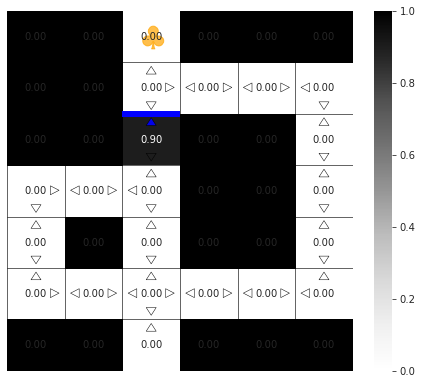

In [139]:
fig = plt.figure(figsize=(6, 5))
ax  = fig.add_axes([0, 0, 1, 1])
plot_maze(ax, agent.Q - Q_before, agent)
plt.savefig('/home/georgy/Documents/Dayan_lab/PhD/bandits/maze/data/replay/examples/tolman123/online_diff.pdf', transparent=True)

In [140]:
Q_before    = agent.Q.copy()

In [141]:
agent.state = 14
agent.M     = np.array([[0, 1], [1, 0], [1, 0]])
Q_history, gain_history, need_history = agent._replay()

1 - Replay 1/3 [<20, (0.00, 1.00, 1.00)>, 0] horizon 1, q_old: 0.81, q_new: 0.23, gain: 0.04, need: 4.70, evb: 0.18
1 - Replay 2/3 [<26, (0.00, 1.00, 1.00)>, 0] horizon 2, q_old: 0.73, q_new: 0.25, gain: 0.05, need: 0.00, evb: 0.18
1 - Replay 3/3 [<32, (0.00, 1.00, 1.00)>, 0] horizon 3, q_old: 0.66, q_new: 0.28, gain: 0.05, need: 0.00, evb: 0.18


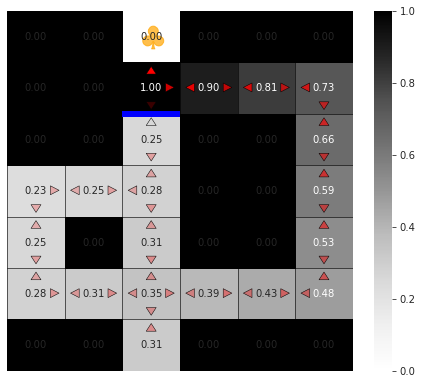

In [142]:
fig = plt.figure(figsize=(6, 5))
ax  = fig.add_axes([0, 0, 1, 1])
plot_maze(ax, agent.Q, agent)
plt.savefig('/home/georgy/Documents/Dayan_lab/PhD/bandits/maze/data/replay/examples/tolman123/replay_negative.pdf', transparent=True)

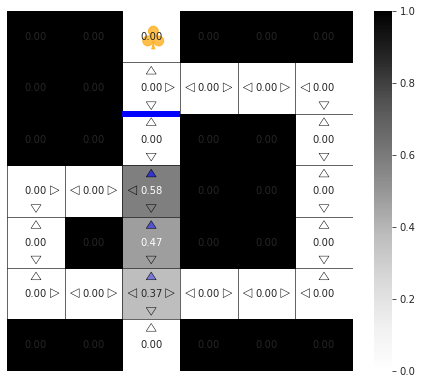

In [143]:
fig = plt.figure(figsize=(6, 5))
ax  = fig.add_axes([0, 0, 1, 1])
plot_maze(ax, agent.Q - Q_before, agent)
plt.savefig('/home/georgy/Documents/Dayan_lab/PhD/bandits/maze/data/replay/examples/tolman123/replay_negative_diff.pdf', transparent=True)

### Exploration probability

In [ ]:
np.random.seed(0)

agent.state  = 38 # start state
M_range      = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
qs           = []

for M in M_range:
    agent.Q  = Q_MB.copy()
    agent.M  = M
    
    _, _, _  = agent._replay()
    
    Q_after  = agent.Q.copy()
    
    qs      += [Q_after[14, :].copy(), Q_after[20, :].copy(), Q_after[26, :].copy(), Q_after[32, :].copy()]

In [ ]:
betas = [1, 5, 10, 20]
for beta in betas:

    agent.online_beta = beta
    probs = np.zeros(len(M_range))
    for i in range(0, len(qs), 4):
        probs[i//4] = agent._policy(qs[i])[0]*agent._policy(qs[i+1])[0]*agent._policy(qs[i+2])[0]*agent._policy(qs[i+3])[0]
    plt.plot(np.array(M_range), probs, label=r'$\beta=%u$'%beta)

probs = np.zeros(len(M_range))
for i in range(0, len(qs), 4):
    probs[i//4] = (qs[i][0] == np.nanmax(qs[i]))*(qs[i+1][0] == np.nanmax(qs[i+1]))*(qs[i+2][0] == np.nanmax(qs[i+2]))*(qs[i+3][0] == np.nanmax(qs[i+3]))
plt.plot(np.array(M_range), probs, label='greedy')

plt.ylim(-0.05, 1.05)
plt.xlim(0, 1)
# plt.xticks(np.linspace(0, 1, 11), np.linspace(0, 1, 11), fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Belief', fontsize=14)
plt.ylabel('Exploration probability', fontsize=14)
plt.legend(prop={'size':12})
# plt.savefig('/home/georgy/Documents/Dayan_lab/PhD/bandits/maze/data/rldm_poster/tolman1/explore_proba.svg', transparent=True)